## Classification models

Classify songs into genres based on musical features

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    classification_report,
    confusion_matrix,
    top_k_accuracy_score
)
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb

from tqdm import tqdm
from src.data_loader import load_processed_data

Read preprocessed data (produced in genre_clustering.ipynb)

In [38]:
df = load_processed_data(scaled=True)

Label encode target variable (genre)

In [39]:
# Separate features and target
X = df.drop('track_genre', axis=1).values
y = df['track_genre'].values

# Label encode the target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
genre_names = label_encoder.classes_

print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(genre_names)}")
print(f"Class names: {genre_names}")

Number of features: 28
Number of classes: 62
Class names: ['afrobeat' 'alt-rock' 'ambient' 'anime-club' 'black-metal' 'bluegrass'
 'breakbeat' 'children' 'classical' 'comedy' 'country-soul' 'death-metal'
 'deep-electronic' 'disco-ska' 'disney-guitar' 'drum-and-bass' 'emo'
 'forro' 'france-and-diaspora' 'funk-hip-hop' 'german' 'grindcore'
 'groovy-electronic' 'hardcore' 'hardcore-happy' 'heavy-grunge'
 'heavy-rock' 'idm' 'indie-and-blues' 'iranian' 'j-dancehall' 'j-idol'
 'jazz-tango' 'kids' 'laid-back' 'latin-dance' 'metalcore'
 'minimal-techno' 'new-age' 'opera' 'party' 'piano' 'pop' 'power-pop'
 'punk-rock' 'rnb' 'rock-n-roll' 'romance' 'roots' 'salsa' 'show-tunes'
 'sleep' 'study' 'techno' 'trance' 'trip-hop' 'us-techno-house'
 'vocal-pop' 'wavy-rock' 'world-folk' 'world-pop' 'world-rhythm']


Perform train-test split

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded  # Ensure balanced split
)

# Convert to float32 for TensorFlow
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (90840, 28)
Test set: (22710, 28)


Import evaluation functions

In [41]:
from src.model_evaluation import (
    evaluate_model,
    plot_confusion_matrix,
    plot_training_history,
    plot_model_comparison,
    save_metrics_json
)

Build Neural network classifier.

Architecture:
- 5 hidden layers with decreasing units (256 → 128 → 64 → 32)
- ReLU activation functions
- Softmax output layer
- Adam optimizer

In [42]:
num_classes = len(genre_names)
input_dim = X_train.shape[1]

# Build neural network
nn_model = keras.Sequential([
    keras.Input(shape=(input_dim,)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Define top-k accuracy metric
sparse_top_3_accuracy = keras.metrics.SparseTopKCategoricalAccuracy(
    k=3, name='top_3_accuracy'
)

# Compile model
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', sparse_top_3_accuracy]
)

# Display architecture
nn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 62)             │         2,046 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,702 (205.87 KB)

 Trainable params: 52,702 (205.87 KB)

 Non-trainable params: 0 (0.00 B)

Train neural network. Implement early stopping to prevent overfitting.

Training Neural Network...
Epoch 1/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0624 - loss: 3.8988 - top_3_accuracy: 0.1516 - val_accuracy: 0.1292 - val_loss: 3.5574 - val_top_3_accuracy: 0.2576
Epoch 2/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1370 - loss: 3.4487 - top_3_accuracy: 0.2840 - val_accuracy: 0.1808 - val_loss: 3.1882 - val_top_3_accuracy: 0.3509
Epoch 3/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1679 - loss: 3.2253 - top_3_accuracy: 0.3390 - val_accuracy: 0.2065 - val_loss: 3.0198 - val_top_3_accuracy: 0.4015
Epoch 4/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1901 - loss: 3.1037 - top_3_accuracy: 0.3735 - val_accuracy: 0.2276 - val_loss: 2.9194 - val_top_3_accuracy: 0.4325
Epoch 5/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2026 - loss: 3.0260 - top_3_accuracy: 0.3964 - val_accuracy: 0.2412 - val_loss: 2.8450 - val_top_3_accuracy: 0.4539
Epoch 6/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy:

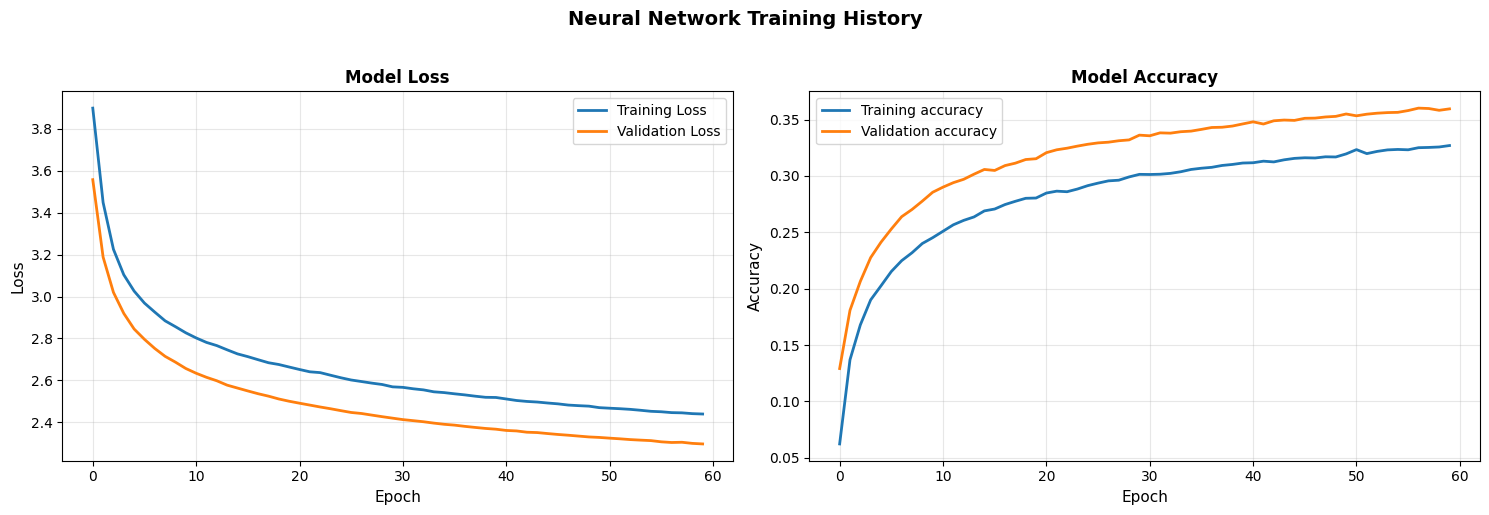

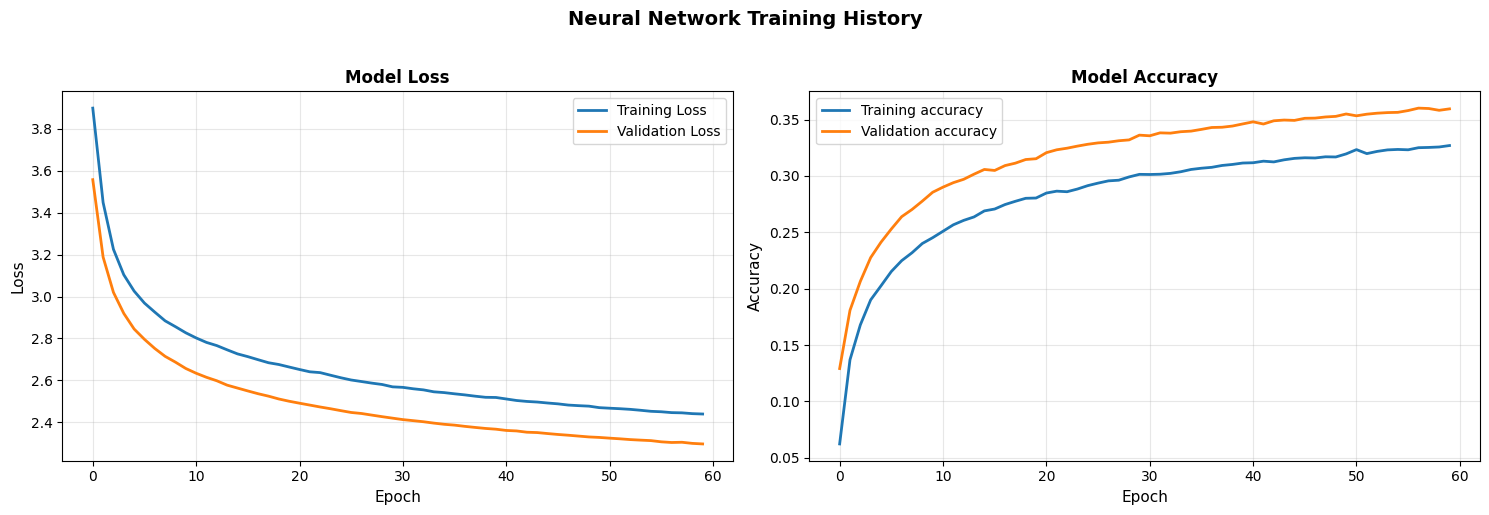

In [43]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train model
print("Training Neural Network...")
history_nn = nn_model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plot_training_history(
    history_nn, 
    title="Neural Network Training History",
    save_path='results/figures/training_history_nn.png'
)

Evaluate neural network

In [ ]:
# Make predictions
y_pred_nn_proba = nn_model.predict(X_test)
y_pred_nn = np.argmax(y_pred_nn_proba, axis=1)

# Evaluate (now using imported function)
nn_results = evaluate_model(
    y_true=y_test, 
    y_pred=y_pred_nn, 
    y_pred_proba=y_pred_nn_proba,
    genre_names=genre_names,
    model_name="Neural Network"
)

# Plot confusion matrix with save option
plot_confusion_matrix(
    y_test, y_pred_nn, 
    genre_names=genre_names,
    title="Neural Network Confusion Matrix",
    save_path='results/figures/confusion_matrix_nn.png'
)


710/710 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step

Neural Network Results
Accuracy: 0.3594 (35.94%)
Top-3 Accuracy: 0.5967 (59.67%)
Top-5 Accuracy: 0.7113 (71.13%)
Top-10 Accuracy: 0.8562 (85.62%)

Classification Report:
                     precision    recall  f1-score   support

           afrobeat       0.38      0.27      0.32       200
           alt-rock       0.16      0.08      0.10       400
            ambient       0.28      0.23      0.25       200
         anime-club       0.25      0.03      0.05       399
        black-metal       0.56      0.52      0.54       199
          bluegrass       0.35      0.43      0.39       200
          breakbeat       0.45      0.23      0.30       200
           children       0.39      0.32      0.35       200
          classical       0.48      0.51      0.50       187
             comedy       0.89      0.79      0.84       199
       country-soul       0.21      0.40      0.27       400
        death-metal       0.34      0.32      0.33   

/home/jacob/Documents/ml_practice/song_genre_prediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jacob/Documents/ml_practice/song_genre_prediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jacob/Documents/ml_practice/song_genre_prediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

Train an XGBoost model for comparison

In [ ]:
# Build XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    max_depth=8,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
    eval_metric='mlogloss'
)

# Train model
print("Training XGBoost...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print("XGBoost training complete")

Training XGBoost...
[0]	validation_0-mlogloss:3.55764
[1]	validation_0-mlogloss:3.34144
[2]	validation_0-mlogloss:3.18218
[3]	validation_0-mlogloss:3.05878
[4]	validation_0-mlogloss:2.95339
[5]	validation_0-mlogloss:2.86396
[6]	validation_0-mlogloss:2.78599
[7]	validation_0-mlogloss:2.71846
[8]	validation_0-mlogloss:2.65811
[9]	validation_0-mlogloss:2.60458
[10]	validation_0-mlogloss:2.55619
[11]	validation_0-mlogloss:2.51220
[12]	validation_0-mlogloss:2.47183
[13]	validation_0-mlogloss:2.43487
[14]	validation_0-mlogloss:2.40178
[15]	validation_0-mlogloss:2.37098
[16]	validation_0-mlogloss:2.34255
[17]	validation_0-mlogloss:2.31646
[18]	validation_0-mlogloss:2.29204
[19]	validation_0-mlogloss:2.26909
[20]	validation_0-mlogloss:2.24831
[21]	validation_0-mlogloss:2.22885
[22]	validation_0-mlogloss:2.21038
[23]	validation_0-mlogloss:2.19333
[24]	validation_0-mlogloss:2.17752
[25]	validation_0-mlogloss:2.16283
[26]	validation_0-mlogloss:2.14878
[27]	validation_0-mlogloss:2.13516
[28]	valid

Evaluate XGBoost


XGBoost Results
Accuracy: 0.4572 (45.72%)
Top-3 Accuracy: 0.7135 (71.35%)
Top-5 Accuracy: 0.8089 (80.89%)
Top-10 Accuracy: 0.9120 (91.20%)

Classification Report:
                     precision    recall  f1-score   support

           afrobeat       0.40      0.39      0.40       200
           alt-rock       0.24      0.24      0.24       400
            ambient       0.31      0.32      0.31       200
         anime-club       0.37      0.26      0.31       399
        black-metal       0.60      0.58      0.59       199
          bluegrass       0.47      0.49      0.48       200
          breakbeat       0.50      0.35      0.41       200
           children       0.66      0.46      0.54       200
          classical       0.52      0.47      0.50       187
             comedy       0.92      0.83      0.87       199
       country-soul       0.49      0.40      0.44       400
        death-metal       0.34      0.34      0.34       200
    deep-electronic       0.34      0.36  

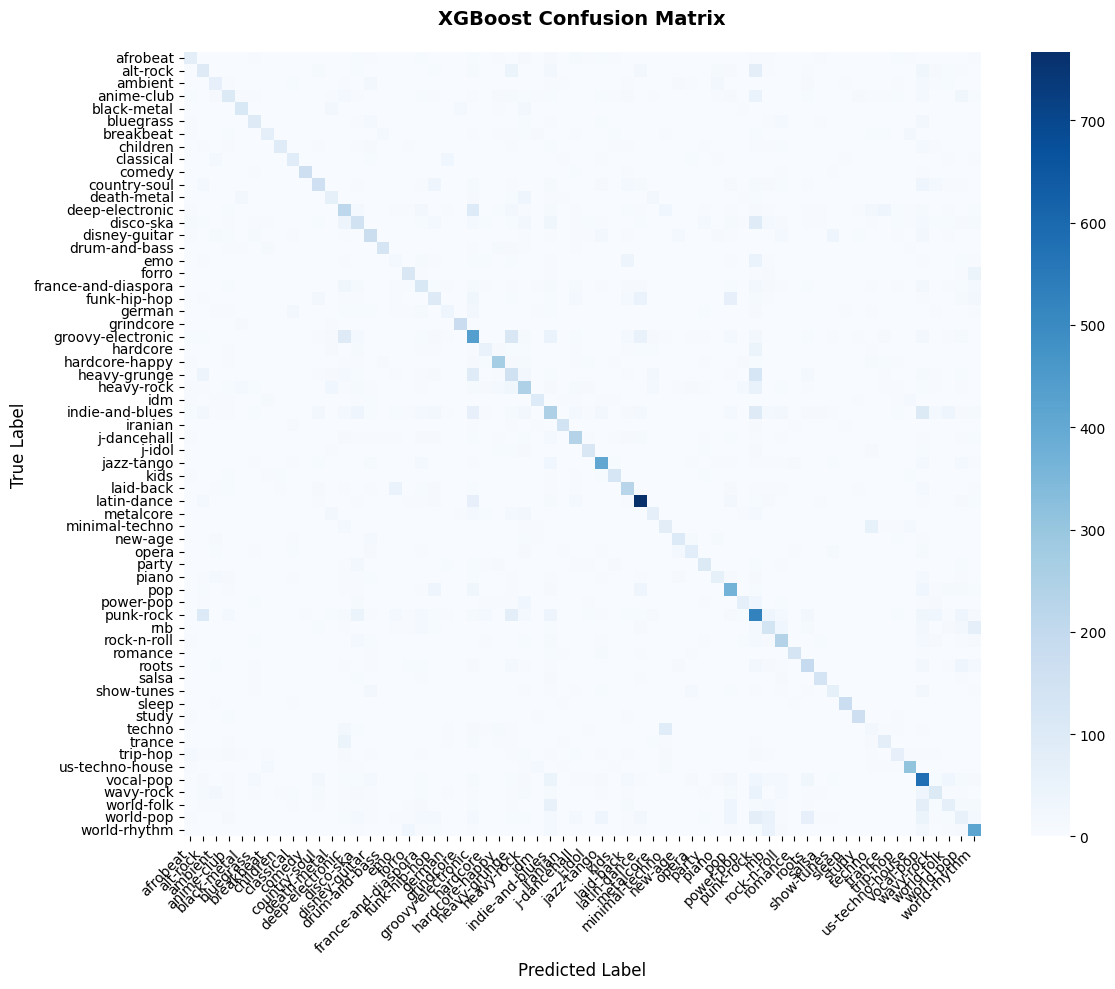

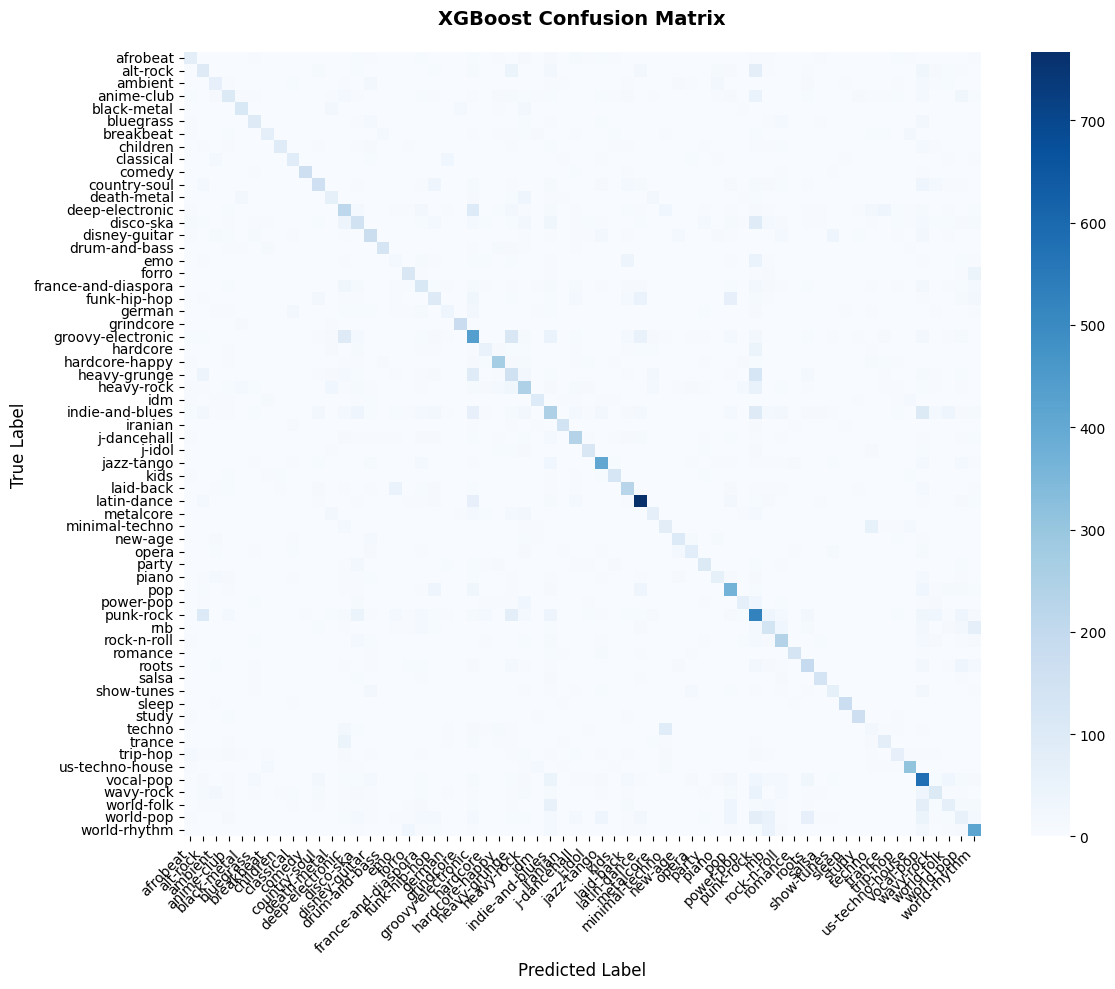

In [ ]:
# Make predictions
y_pred_xgb_proba = xgb_model.predict_proba(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate (store results in xgb_results variable)
xgb_results = evaluate_model(
    y_true=y_test, 
    y_pred=y_pred_xgb, 
    y_pred_proba=y_pred_xgb_proba,
    genre_names=genre_names,
    model_name="XGBoost"
)

# Plot confusion matrix
plot_confusion_matrix(
    y_test, y_pred_xgb, 
    genre_names=genre_names,
    title="XGBoost Confusion Matrix",
    save_path='results/figures/confusion_matrix_xgb.png'
)


Feature importance from XGBoost

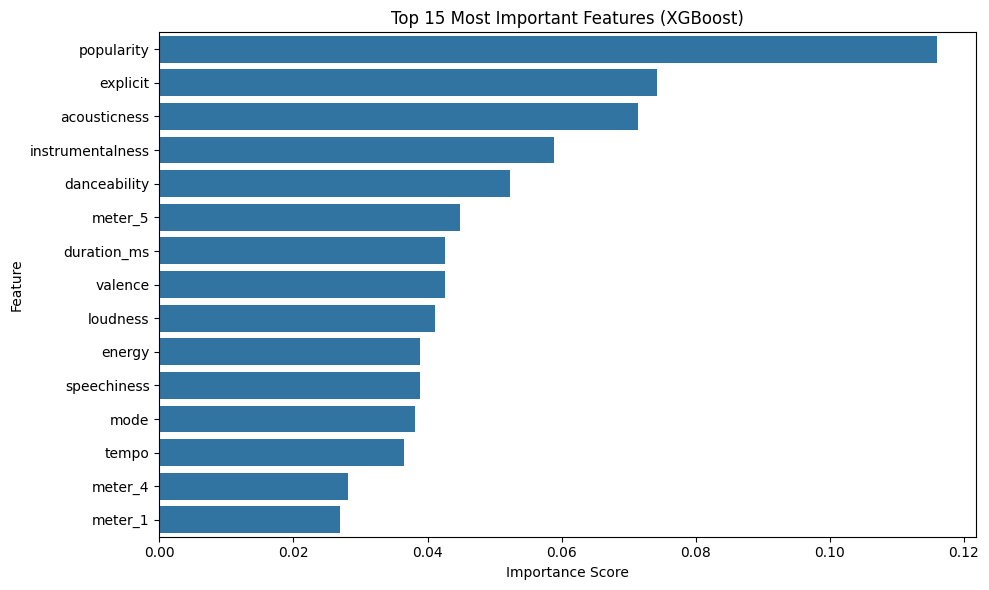


Top 10 Most Important Features:
             feature  importance
17        popularity    0.116019
0           explicit    0.074223
23      acousticness    0.071349
24  instrumentalness    0.058926
19      danceability    0.052332
16           meter_5    0.044860
18       duration_ms    0.042606
26           valence    0.042559
21          loudness    0.041066
20            energy    0.038870


In [ ]:
# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': df.drop('track_genre', axis=1).columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Compare models

Model comparison plot saved to results/figures/model_comparison.png


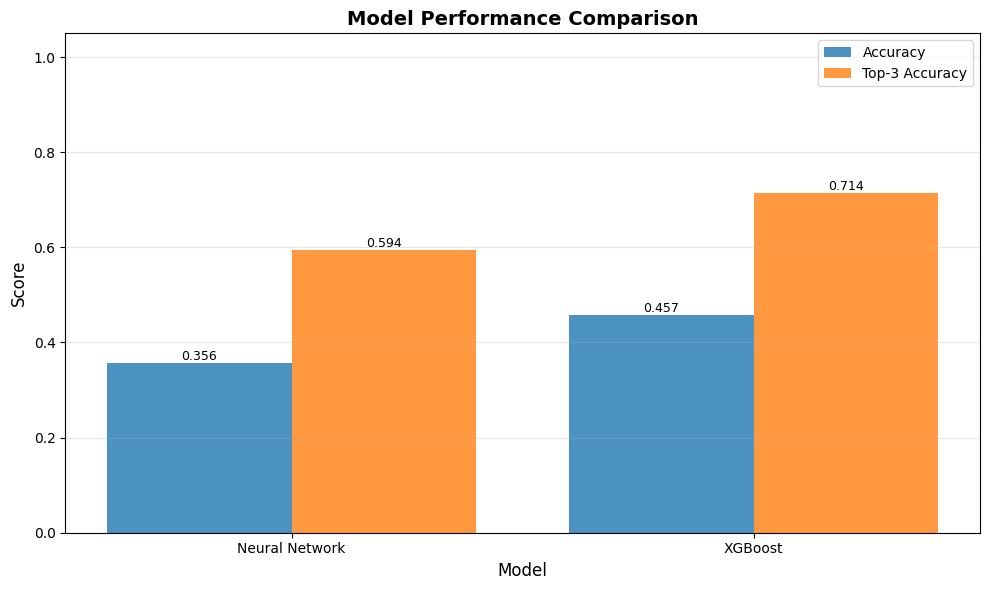

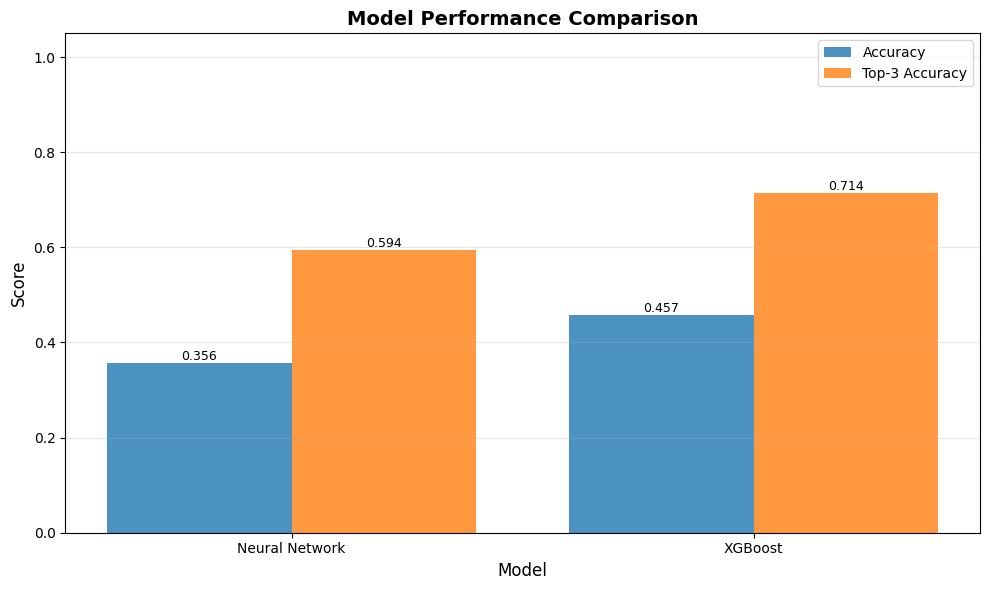

In [ ]:
# CELL 12: Model Comparison (updated)
results_df = pd.DataFrame({
    'Model': ['Neural Network', 'XGBoost'],
    'Accuracy': [nn_results['accuracy'], xgb_results['accuracy']],
    'Top-3 Accuracy': [nn_results['top_3_accuracy'], xgb_results['top_3_accuracy']]
})

# Plot comparison
plot_model_comparison(
    results_df,
    metrics=['Accuracy', 'Top-3 Accuracy'],
    title='Model Performance Comparison',
    save_path='results/figures/model_comparison.png'
)


Save metrics

In [ ]:
metrics = {
    'neural_network': nn_results,
    'xgboost': xgb_results,
    'best_model': 'neural_network' if nn_results['accuracy'] > xgb_results['accuracy'] else 'xgboost'
}

save_metrics_json(metrics, 'results/metrics/model_performance.json')


Summary:

In [ ]:
print("Classification modeling complete")
print(f"\nBest performing model: {'Neural Network' if nn_results['accuracy'] > xgb_results['accuracy'] else 'XGBoost'}")
print(f"Best accuracy: {max(nn_results['accuracy'], xgb_results['accuracy']):.4f}")


Classification modeling complete

Best performing model: XGBoost
Best accuracy: 0.4572
